In [3]:
import torch
import torch.autograd
from torch.autograd import Variable
from torch import autograd
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import time
import sys
sys.path.append(os.path.join(os.getcwd(), '..', 'utils'))
from compute_tau import compute_tau_star
import matplotlib.patches as mpatches
import scipy.sparse.linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()
sns.set_style("whitegrid",  {"grid.linewidth": 0.6})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
figsize = (8, 6)
figsize2 = (16, 6)
marker_list = ['o', 'v', 's', 'P', '*', 'X', 'D']
cmap = plt.get_cmap("tab10")
cmap2 = plt.get_cmap("tab20")
contour_cmap = plt.cm.get_cmap('Greys_r')
contour_points = 100000
alpha = .6
fig_dir = os.path.join(os.getcwd(), 'polynomial_figs')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
ss= 250
ms=15
ms2=20
ls=20
fs=30
fs2=24
lsp=0.1
htp=.1
ms3=.5
pad = 20
offset=850
auto_limits=True
run_test=True
x_lims_def = [-20, 20]
y_lims_def = [-20, 20]
cmap3 = cm.inferno
xlims_3d =[-25,25]
ylims_3d =[-25,25]
density = 1.25
mew=2
slw = 2.5
verbose=True
show=True
save=True
lw=4
frameon=False
a = 0.3
b = 0.3

## Game and Derivatives

In [4]:
def f1_func(x, y, a, b):
    return -np.exp(-0.01*x**2 - 0.01*y**2)*((a*x**2 + y)**2+(b*y**2+x)**2)   

def f1_func_torch(x, y, a, b):
    return -torch.exp(-0.01*x**2 - 0.01*y**2)*((a*x**2 + y)**2+(b*y**2+x)**2)   

def f2_func(x, y, a, b):
    return np.exp(-0.01*x**2 - 0.01*y**2)*((a*x**2 + y)**2+(b*y**2+x)**2)   

def f2_func_torch(x, y, a, b):
    return torch.exp(-0.01*x**2 - 0.01*y**2)*((a*x**2 + y)**2+(b*y**2+x)**2) 

def d1f1_func(x, y, a, b):
    return np.exp(-0.01*x**2 - 0.01*y**2)*(0.02*x*((a*x**2 + y)**2+(b*y**2+x)**2) - 2*(b*y**2 + x) - 4*a*x*(a*x**2 + y))  

def d1f1_func_torch(x, y, a, b):
    return torch.exp(-0.01*x**2 - 0.01*y**2)*(0.02*x*((a*x**2 + y)**2+(b*y**2+x)**2) - 2*(b*y**2 + x) - 4*a*x*(a*x**2 + y)) 

def d2f2_func(x, y, a, b):
    return -np.exp(-0.01*x**2 - 0.01*y**2)*(0.02*y*((a*x**2 + y)**2+(b*y**2+x)**2) - 2*(a*x**2 + y) - 4*b*y*(b*y**2 + x))  

def d2f2_func_torch(x, y, a, b):
    return -torch.exp(-0.01*x**2 - 0.01*y**2)*(0.02*y*((a*x**2 + y)**2+(b*y**2+x)**2) - 2*(a*x**2 + y) - 4*b*y*(b*y**2 + x))

def d2f1_func(x, y, a, b):
    return np.exp(-0.01*x**2 - 0.01*y**2)*(0.02*y*((a*x**2 + y)**2+(b*y**2+x)**2) - 2*(a*x**2 + y) - 4*b*y*(b*y**2 + x))
    
def d11f1_func(x, y, a, b):
    return np.exp(-0.01*x**2 - 0.01*y**2)*(x**2*(-12*a**2 + 0.2*a*y - 0.0004*b**2*y**4 - 0.0004*y**2 + 0.1) -  0.0004*a**2*x**6 + x**4*(0.18*a**2 - 0.0008*a*y - 0.0004) - 4*a*y + 0.02*b**2*y**4 - 0.0008*b*x**3*y**2 + 0.12*b*x*y**2 + 0.02*y**2 - 2)

def d21f2_func(x, y, a, b):    
    return np.exp(-0.01*x**2 - 0.01*y**2)*(0.0004*x*y*((a*x**2 + y)**2 + (b*y**2 + x)**2) - 0.08*a*x*y*(a*x**2 + y) - 0.04*x*(a*x**2 + y) + 4*a*x - 0.08*b*x*y*(b*y**2 + x) - 0.04*y*(b*y**2 + x) + 4*b*y)

def d12f1_func(x, y, a, b):    
    return -np.exp(-0.01*x**2 - 0.01*y**2)*(0.0004*x*y*((a*x**2 + y)**2 + (b*y**2 + x)**2) - 0.08*a*x*y*(a*x**2 + y) - 0.04*x*(a*x**2 + y) + 4*a*x - 0.08*b*x*y*(b*y**2 + x) - 0.04*y*(b*y**2 + x) + 4*b*y)

def d22f2_func(x, y, a, b): 
    return np.exp(-0.01*x**2 - 0.01*y**2)*(a**2*x**4*(0.0004*y**2 - 0.02) + x**2*(0.0008*a*y**3 - 0.12*a*y + 0.0004*y**2 - 0.02) + b**2*(0.0004*y**6 - 0.18*y**4 + 12*y**2) + b*x*(0.0008*y**4 - 0.2*y**2 + 4) + 0.0004*y**4 -0.1*y**2 + 2)

def df1_func(x, y, a, b):
    d1f1 =  d1f1_func(x, y, a, b)                       
    d2f1 = d2f1_func(x, y, a, b)  
    d21f2 = d21f2_func(x, y, a, b)
    d22f2 = d22f2_func(x, y, a, b)
    df1 = d1f1 - d21f2*d2f1/(d22f2)   
    return df1


def J_tau_func(x, y, a, b, tau):
    d11f1 = d11f1_func(x, y, a, b)
    d12f1 = d12f1_func(x, y, a, b)
    d21f2 = d21f2_func(x, y, a, b)
    d22f2 = d22f2_func(x, y, a, b)
    return np.array([[d11f1, d12f1], [tau*d21f2, tau*d22f2]])

if run_test:
    for test_num in range(500):
        x_test = np.random.randint(-20, 20)*np.random.rand()
        y_test = np.random.randint(-20, 20)*np.random.rand()

        x_torch = Variable(torch.Tensor([x_test]), requires_grad=True)
        y_torch = Variable(torch.Tensor([y_test]), requires_grad=True)

        x = x_test
        y = y_test

        assert np.allclose(torch.autograd.grad(f1_func_torch(x_torch, y_torch, a, b), x_torch)[0].item(), d1f1_func(x, y, a, b), 1e-3)
        assert np.allclose(torch.autograd.grad(f1_func_torch(x_torch, y_torch, a, b), y_torch)[0].item(), d2f1_func(x, y, a, b), 1e-3)
        assert np.allclose(torch.autograd.grad(f2_func_torch(x_torch, y_torch, a, b), y_torch)[0].item(), d2f2_func(x, y, a, b), 1e-3)


        assert np.allclose(torch.autograd.grad(d1f1_func_torch(x_torch, y_torch, a, b), x_torch)[0].item(), d11f1_func(x, y, a, b), 1e-3)
        assert np.allclose(torch.autograd.grad(d2f2_func_torch(x_torch, y_torch, a, b), y_torch)[0].item(), d22f2_func(x, y, a, b), 1e-3)
        assert np.allclose(torch.autograd.grad(d1f1_func_torch(x_torch, y_torch, a, b), y_torch)[0].item(), d12f1_func(x, y, a, b), 1e-3)
        assert np.allclose(torch.autograd.grad(d2f2_func_torch(x_torch, y_torch, a, b), x_torch)[0].item(), d21f2_func(x, y, a, b), 1e-3)
        
# From mathematica; see compute_polynomial_critical_points.nb
critical_points = [[1.32905, -13.8201], [-11.0297,  -11.0297], 
                   [10.5722, -8.95174], [-3.33333, -3.33333], 
                   [-1.62165,  -1.62165], [0.,0], [-13.8201,  1.32905], 
                   [13.6434, 2.15788], [9.31806, 9.31806], [-8.95174,  10.5722], [2.15788, 13.6434]]
critical_points = np.array(critical_points)

## Plot Surface and Critical Points

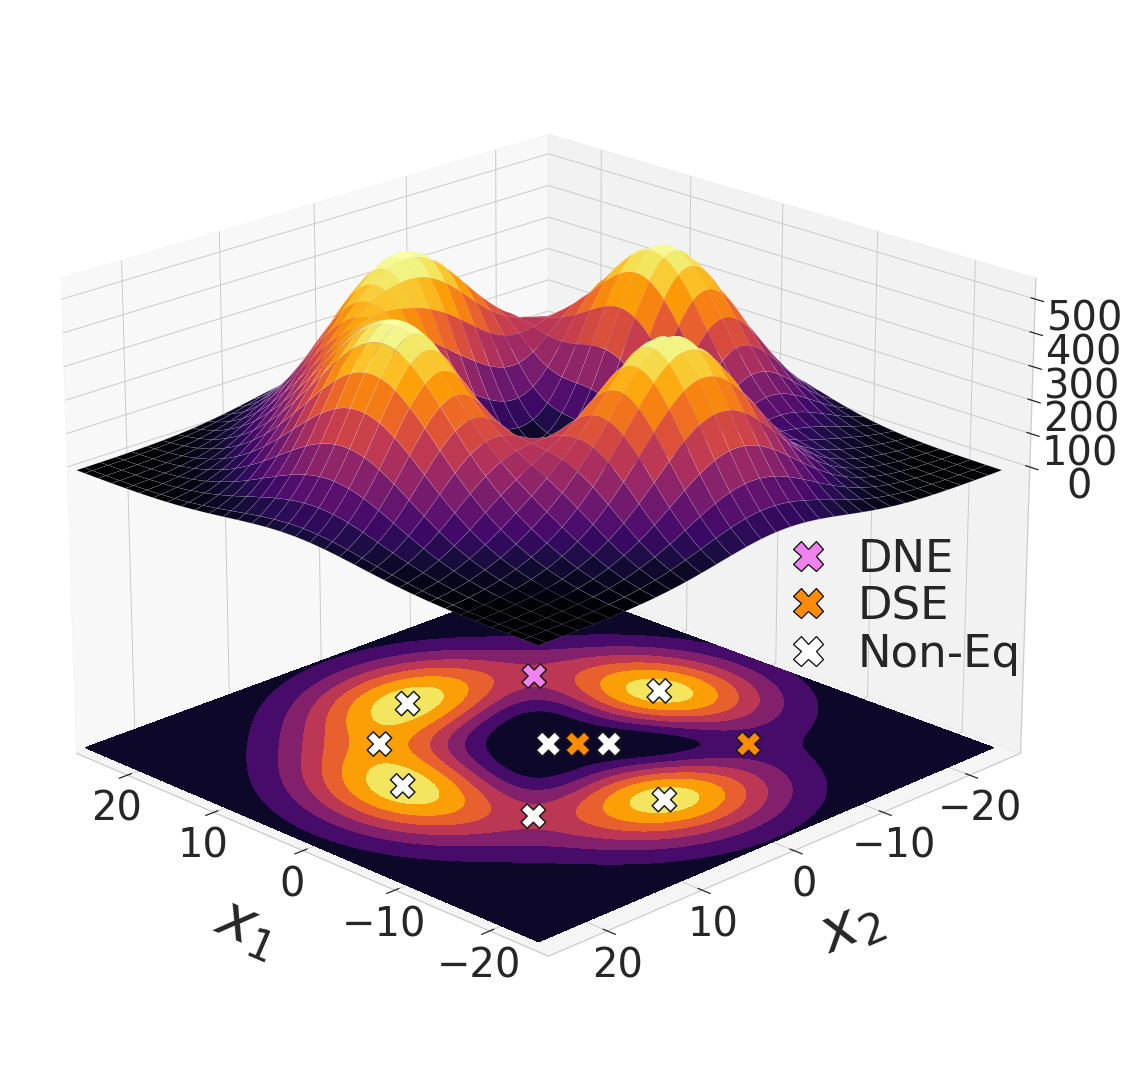

In [6]:
d11f1_arr = d11f1_func(critical_points[:, 0], critical_points[:, 1], a, b)
d22f2_arr = d22f2_func(critical_points[:, 0], critical_points[:, 1], a, b)
d12f1_arr = d12f1_func(critical_points[:, 0], critical_points[:, 1], a, b)
d21f2_arr = d21f2_func(critical_points[:, 0], critical_points[:, 1], a, b)
schur_arr = d11f1_arr-d12f1_arr*d21f2_arr/d22f2_arr

colors = []
markers = []
for i in range(len(critical_points)):
    if d11f1_arr[i] >0 and d22f2_arr[i] >0:
        colors.append('violet')
    elif d11f1_arr[i] <= 0 and d22f2_arr[i] >0 and schur_arr[i] >0:
        colors.append('darkorange')     
    else:
        colors.append('1')

fig = plt.figure(figsize=(20, 15))
ax = plt.axes(projection='3d')
x, y = np.meshgrid(np.linspace(xlims_3d[0],xlims_3d[1], int(np.sqrt(contour_points))+1), np.linspace(ylims_3d[0], ylims_3d[1], int(np.sqrt(contour_points)))+1)
z =  f2_func(x, y, a, b)
surf = ax.plot_surface(x, y, z, rstride=10, cstride=10, alpha=1, cmap=cmap3, edgecolor='1', linewidth=.1)
cset = ax.contourf(x, y, z, offset=np.min(z)-offset, cmap=cmap3, zorder=1)
sset = ax.scatter(critical_points[:, 0], critical_points[:, 1], np.min(z)-offset, s=600, facecolor=colors, edgecolor='.1', linewidth=1.5, alpha=1, marker='X')
    
ax.set_xlabel('$x_1$', fontsize=fs*2, labelpad=40)
ax.set_xlim(xlims_3d[0], xlims_3d[1])
ax.set_ylabel('$x_2$', fontsize=fs*2, labelpad=40)
ax.set_ylim(ylims_3d[0], ylims_3d[1])
ax.set_zlim(np.min(z)-offset, np.max(z))
ax.set_zticks(np.arange(0, 600, 100))
ax.view_init(21, 135)
ax.tick_params(labelsize=ls*2)
ax.tick_params(axis='z', pad=20)

l1, = ax.plot([], [], markeredgewidth=1.2, markeredgecolor='black', markerfacecolor='violet', ls='none', marker='X', markersize=ms2*1.5)
l2, = ax.plot([], [], markeredgewidth=1.2, markeredgecolor='black', markerfacecolor='darkorange', ls='none', marker='X', markersize=ms2*1.5)
l3, = ax.plot([], [], markeredgewidth=1.2, markeredgecolor='black', markerfacecolor='1', ls='none', marker='X', markersize=ms2*1.5)
ax.legend([l1, l2, l3], ['DNE', 'DSE', 'Non-Eq'], fontsize=fs*1.5, labelspacing=lsp, frameon=frameon, handletextpad=htp, bbox_to_anchor=(1.0, .535))

plt.tight_layout()

if save:
    plt.savefig(os.path.join(fig_dir, 'function_3d.png'), bbox_inches='tight')
if show:
    plt.show()

## Run Dynamics

In [7]:
num_epochs = 25000
freq = 30000
learning_rate = 1e-4
tau_list = [1, 2, 5, 20]
#tau_list = [15,25, 30, 35, 100]
x_init = -9
y_init = -9
    
trajectories = []

for tau in tau_list:

    trajectory = []
    x = np.array([x_init])
    y = np.array([y_init])

    z = np.concatenate([x, y]).flatten()

    trajectory.append(z)
    start = time.time()

    for epoch in range(1, num_epochs+1):

        d1f1 = d1f1_func(x, y, a, b)             
        d2f2 = d2f2_func(x, y, a, b)
        x = x - learning_rate * d1f1
        y = y - tau*learning_rate * d2f2
            
        z = np.concatenate([x, y])
        trajectory.append(z)
        dz = np.concatenate([d1f1, d2f2])

        if verbose:
            if epoch % freq == 0:
                print(epoch, z)

    trajectory = np.vstack(trajectory)
    trajectories.append(trajectory)

    end = time.time()

    if verbose:
        print('Finished in {:.2f} Seconds'.format(end-start))

Finished in 1.09 Seconds
Finished in 1.04 Seconds
Finished in 1.08 Seconds
Finished in 1.03 Seconds


## Plot Trajectories

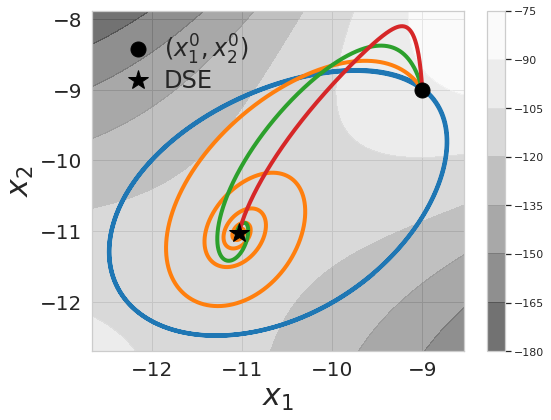

In [8]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
critical_point = [-11.0297,  -11.0297]

for i, trajectory in enumerate(trajectories):
    ax.plot(trajectory[:, 0], trajectory[:, 1], color=cmap(i), lw=lw)

ax.plot(trajectory[0, 0], trajectory[0, 1], color='black', marker='o', markersize=ms, ls='none', label=r'$(x_1^{0}, x_2^{0})$')
ax.plot(critical_point[0], critical_point[1], color='black', marker='*', markersize=ms2, ls='none', label=r'DSE')
if auto_limits:
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
else:
    xlims = x_lims_def
    ylims = y_lims_def
x, y = np.meshgrid(np.linspace(xlims[0],xlims[1], np.sqrt(contour_points).astype(int)), np.linspace(ylims[0], ylims[1], np.sqrt(contour_points).astype(int)))
z = f1_func(x, y, a, b)
im = ax.contourf(x, y, z, cmap=contour_cmap, alpha=alpha)
fig.colorbar(im)        
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel('$x_1$', fontsize=fs)
ax.set_ylabel('$x_2$', fontsize=fs)
ax.tick_params(labelsize=ls)
plt.legend(fontsize=fs2, labelspacing=lsp, frameon=frameon, handletextpad=htp, loc='best')
plt.tight_layout()

if save:
    plt.savefig(os.path.join(fig_dir, 'simgrad_x_y.png'), bbox_inches='tight')
if show:
    plt.show()

## Plot Vector Field

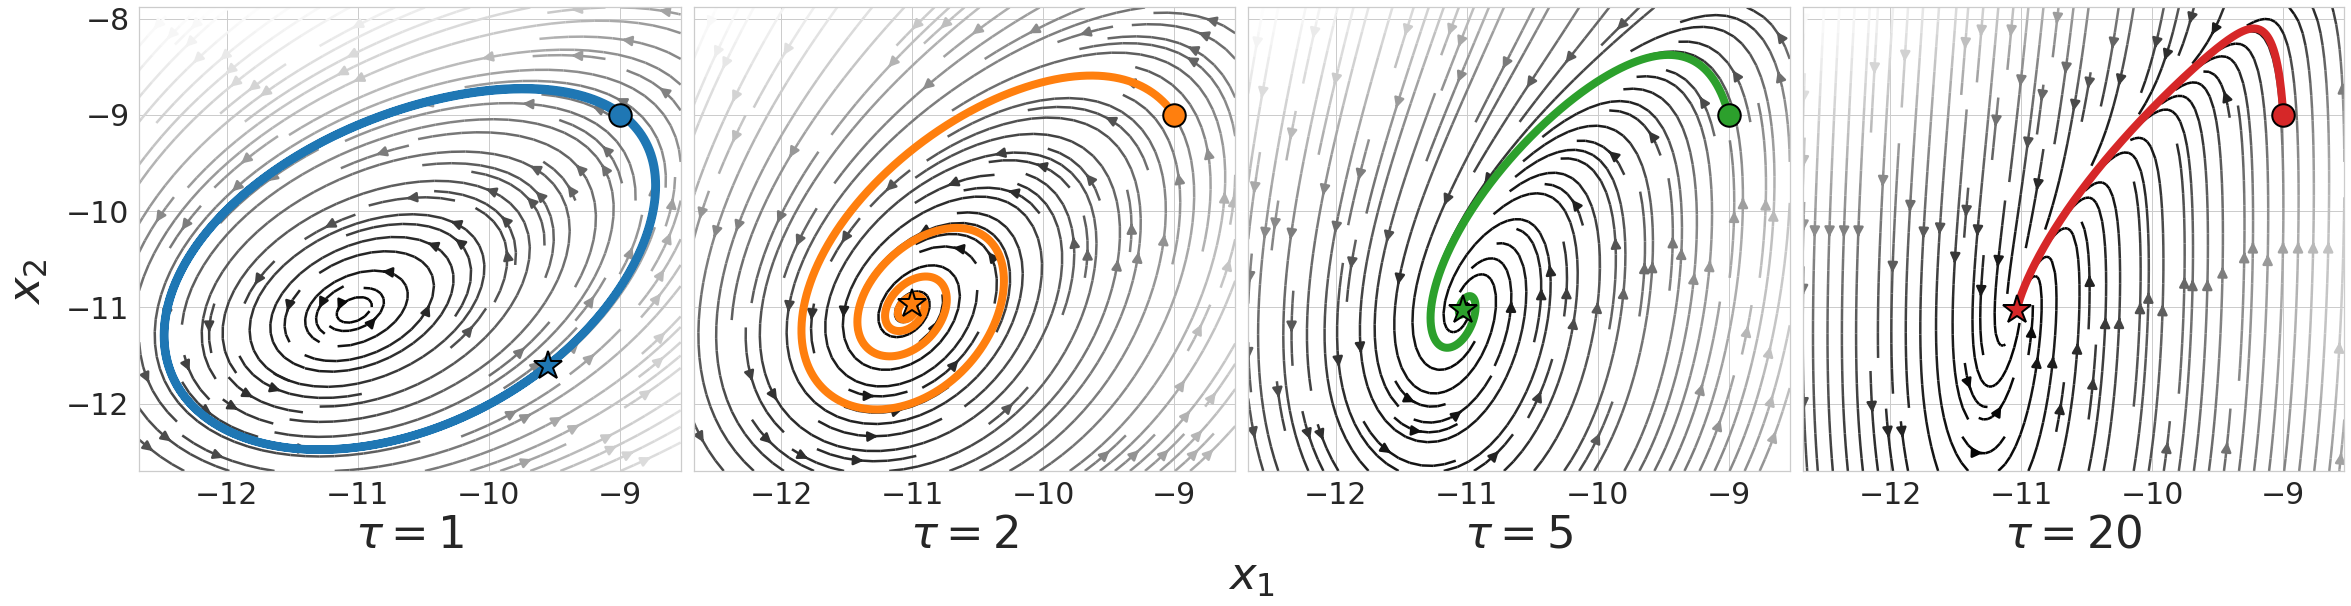

In [9]:
tau_list = [1, 2, 5, 20]
fig, ax = plt.subplots(1, len(tau_list), figsize=(8*len(tau_list), 8), sharex=True, sharey=True)
if not auto_limits:
    xlims = x_lims_def
    ylims = y_lims_def
for count, tau in enumerate(tau_list):
    x, y = np.meshgrid(np.linspace(xlims[0],xlims[1], int(np.sqrt(contour_points))), np.linspace(ylims[0], ylims[1], int(np.sqrt(contour_points))))
    z1 = -d1f1_func(x, y, a, b)
    z2 = -tau*d2f2_func(x, y, a, b)
    z3 = np.sqrt(z1**2 + z2**2)
    z3 = z3/z3.max()
    ax[count].streamplot(x, y, z1, z2, color=z3, cmap=contour_cmap, density=density, linewidth=slw, arrowsize=2)
    trajectory = trajectories[count]
    ax[count].plot(trajectory[:, 0], trajectory[:, 1], color=cmap(count), lw=lw*2)
    ax[count].plot(trajectory[-1, 0], trajectory[-1, 1], color=cmap(count), markeredgecolor='black', marker='*', markersize=ms2*1.5, ls='none', markeredgewidth=mew)
    ax[count].plot(trajectory[0, 0], trajectory[0, 1], color=cmap(count), markeredgecolor='black', marker='o', markersize=ms*1.5, ls='none', markeredgewidth=mew)
    ax[count].set_xlim(xlims)
    ax[count].set_ylim(ylims)
    ax[count].tick_params(labelsize=ls*1.5)
    ax[count].set_xticks([-12, -11, -10, -9])
    ax[count].set_xlabel(r'$\tau=%d$'%tau, fontsize=fs*1.5)

fig.text(0.52, -0.035, '$x_1$', ha='center', fontsize=fs*1.5)
fig.text(-0.02, 0.5, '$x_2$', va='center', rotation='vertical', fontsize=fs*1.5)
plt.tight_layout()


if save:
    plt.savefig(os.path.join(fig_dir, 'simgrad_vfield.png'), bbox_inches='tight')
if show:
    plt.show()

## Plot Distance to Equilibria

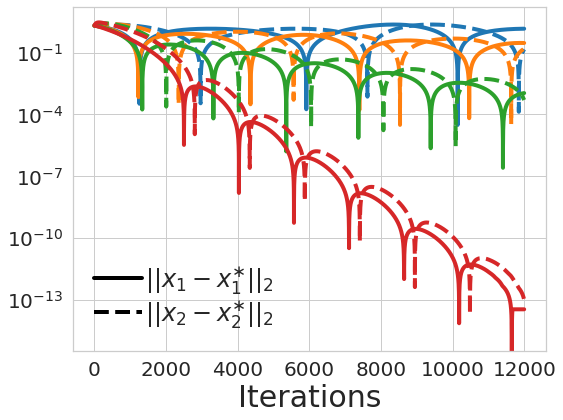

In [10]:
# higher precision for the critical point.
critical_points[1] = [-11.029738508573407, -11.029738508573407]
fig, ax = plt.subplots(1, 1, figsize=figsize)
for i, trajectory in enumerate(trajectories):
    ax.plot(np.abs(trajectory[:12000, 0]-critical_points[1, 0]), color=cmap(i), lw=lw, ls='-')
    ax.plot(np.abs(trajectory[:12000, 1]-critical_points[1, 1]), color=cmap(i), lw=lw, ls='--')       
ax.set_xlabel('Iterations', fontsize=fs)
ax.tick_params(labelsize=ls)
ax.set_yscale('log')
ax.plot([], [], color='black', label=r'$||x_1-x_1^{\ast}||_2$', ls='-', lw=lw)
ax.plot([], [], color='black', label=r'$||x_2-x_2^{\ast}||_2$', ls='--', lw=lw)
plt.legend(fontsize=fs2, labelspacing=lsp, frameon=frameon, handletextpad=htp, loc='lower left')
plt.tight_layout()
if save:
    plt.savefig(os.path.join(fig_dir, 'simgrad_distance.png'), bbox_inches='tight')
if show:
    plt.show()

## Plot Region of Attraction

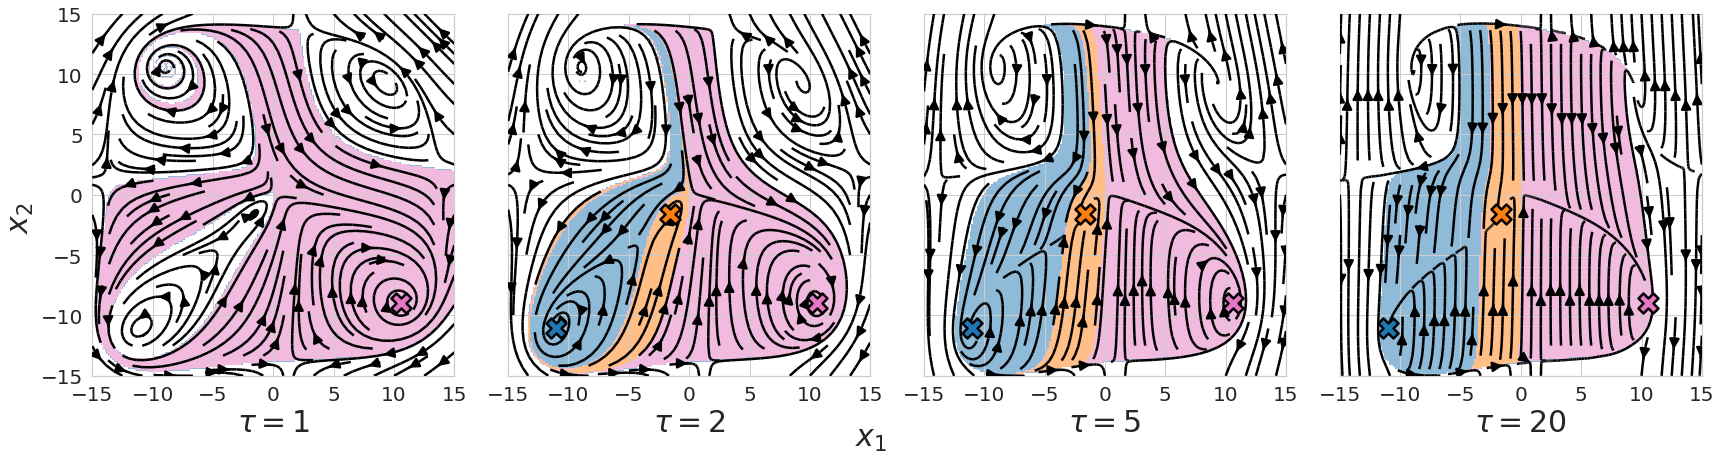

In [11]:
roa_points = 200
num_iters = 75000
learning_rate = 1e-3
xlims_roa = [-15, 15]
ylims_roa = [-15, 15]
tau_list = [1, 2, 5, 20]
cmap_roa = plt.get_cmap("Paired")
fig, ax = plt.subplots(1, len(tau_list), figsize=(6*len(tau_list), 6), sharex=True, sharey=True)
for tau_num, tau in enumerate(tau_list):
    x_inits, y_inits = np.meshgrid(np.linspace(xlims_roa[0],xlims_roa[1], roa_points), np.linspace(ylims_roa[0], ylims_roa[1], roa_points))
    z = np.zeros(x_inits.shape)

    x = x_inits
    y = y_inits

    for count in range(num_iters+1):
        x = x - learning_rate * d1f1_func(x, y, a, b)      
        y = y - tau*learning_rate * d2f2_func(x, y, a, b)

    condition1 = (np.min(np.array([np.sqrt(np.power(x-critical_points[i, 0], 2)+ np.power(y-critical_points[i, 1], 2)) for i in range(len(critical_points))]), axis=0)<1e-3) 
    z = -1*np.ones(x_inits.shape)
    z[condition1] = np.argmin(np.array([np.sqrt(np.power(x-critical_points[i, 0], 2)+ np.power(y-critical_points[i, 1], 2)) for i in range(len(critical_points))]), axis=0)[condition1]
    cmap_custom = ListedColormap(['white', cmap(0), cmap(6), cmap(1)])
    z1 = -d1f1_func(x_inits, y_inits, a, b)
    z2 = -tau*d2f2_func(x_inits, y_inits, a, b)
    ax[tau_num].imshow(z, origin='lower', extent=xlims_roa+ylims_roa, zorder=-20, cmap=cmap_custom, alpha=.5, vmin=-1, vmax=cmap_custom.N)
    ax[tau_num].streamplot(x_inits, y_inits, z1, z2, color='black', density=density, linewidth=slw, arrowsize=2, zorder=5)
    if tau > 1:
        ax[tau_num].scatter(critical_points[1, 0], critical_points[1, 1], s=400, zorder=10, edgecolor='black', lw=2.5, color=cmap_custom(1), marker='X')
    ax[tau_num].scatter(critical_points[2, 0], critical_points[2, 1], s=400, zorder=10, edgecolor='black', lw=2.5, color=cmap_custom(2), marker='X')
    if tau>1:
        ax[tau_num].scatter(critical_points[4, 0], critical_points[4, 1], s=400, zorder=10, edgecolor='black', lw=2.5, color=cmap_custom(3), marker='X')
    ax[tau_num].set_xlim([-15, 15])
    ax[tau_num].set_ylim([-15, 15])
    ax[tau_num].tick_params(labelsize=ls)
    ax[tau_num].set_xlabel(r'$\tau=%d$'%tau, fontsize=fs)

fig.text(0.5, -0.03, '$x_1$', ha='center', fontsize=fs)
fig.text(-0.0, 0.5, '$x_2$', va='center', rotation='vertical', fontsize=fs)
plt.tight_layout()
if save:
    plt.savefig(os.path.join(fig_dir, 'roa.png'), bbox_inches='tight')
if show:
    plt.show()

## Plot Eigenvalues

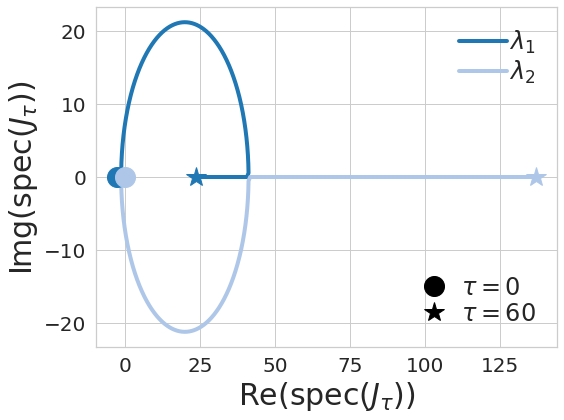

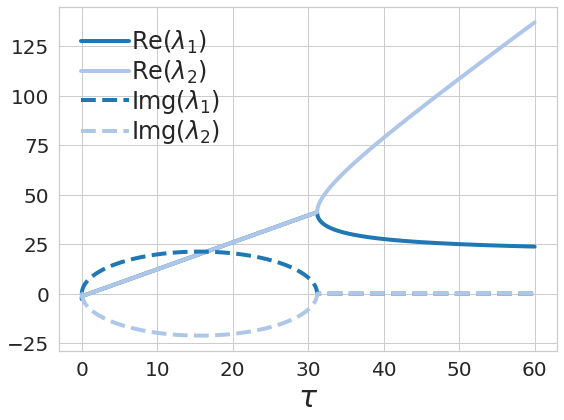

In [21]:
tau_min = 0
tau_max = 60
tau_step = .01
x, y = critical_points[1]
tau_sweep = np.arange(tau_min, tau_max, tau_step)
eigs = [np.linalg.eigvals(J_tau_func(x, y, a, b, tau)) for tau in tau_sweep]
eigs = np.vstack(eigs)

fig, ax = plt.subplots(1, 1, figsize=figsize)

ax.plot(np.real(eigs[:, 0]), np.imag(eigs[:, 0]), '-', lw=lw, color=cmap2(0), markersize=ms3, label=r'$\lambda_1$')
ax.plot(np.real(eigs[:, 1]), np.imag(eigs[:, 1]), '-', lw=lw, color=cmap2(1), markersize=ms3, label=r'$\lambda_2$')

ax.plot(np.real(eigs[0, 0]), np.imag(eigs[0, 0]), color=cmap2(0), marker='o', markersize=ms2)
ax.plot(np.real(eigs[0, 1]), np.imag(eigs[0, 1]), color=cmap2(1), marker='o', markersize=ms2)

ax.plot(np.real(eigs[-1, 0]), np.imag(eigs[-1, 0]), color=cmap2(0), marker='*', markersize=ms2)
ax.plot(np.real(eigs[-1, 1]), np.imag(eigs[-1, 1]), color=cmap2(1), marker='*', markersize=ms2)

ax.set_ylabel(r'Img(spec($J_{\tau}$))', fontsize=fs)
ax.set_xlabel(r'Re(spec($J_{\tau}$))', fontsize=fs)
ax.tick_params(labelsize=ls)
legend1 = ax.legend(fontsize=fs2, labelspacing=lsp, frameon=frameon, handletextpad=htp)

l1, = ax.plot([], [], color='black', ls='none', marker='o', markersize=ms2)
l2, = ax.plot([], [], color='black', ls='none', marker='*', markersize=ms2)
legend2 = ax.legend([l1, l2], [r'$\tau=$'+str(tau_min), r'$\tau=$'+str(tau_max)], fontsize=fs2, labelspacing=lsp, frameon=frameon, handletextpad=htp, loc='lower right')

ax.add_artist(legend1)
plt.tight_layout()

if save:
    plt.savefig(os.path.join(fig_dir, 'tau_eig_sweep1.png'), bbox_inches='tight')
if show:
    plt.show()

fig, ax = plt.subplots(1, 1, figsize=figsize)

ax.plot(tau_sweep, np.real(eigs[:, 0]), '-', lw=lw, color=cmap2(0), markersize=ms3, label=r'Re($\lambda_1$)')
ax.plot(tau_sweep, np.real(eigs[:, 1]), '-', lw=lw, color=cmap2(1), markersize=ms3, label=r'Re($\lambda_2$)')

ax.plot(tau_sweep, np.imag(eigs[:, 0]), '-', lw=lw, color=cmap2(0), markersize=ms3, label=r'Img($\lambda_1)$', ls='--')
ax.plot(tau_sweep, np.imag(eigs[:, 1]), '-', lw=lw, color=cmap2(1), markersize=ms3, label=r'Img($\lambda_2)$', ls='--')
ax.set_xlabel(r'$\tau$', fontsize=fs)
ax.tick_params(labelsize=ls)
ax.legend(fontsize=fs2, labelspacing=lsp, frameon=frameon, handletextpad=htp)
plt.tight_layout()

if save:
    plt.savefig(os.path.join(fig_dir, 'tau_eig_sweep2.png'), bbox_inches='tight')
if show:
    plt.show()

## Compute $\tau^{\ast}$

In [22]:
m = 1
n = 1
for critical_point in critical_points:
    x, y = critical_point
    J = J_tau_func(x, y, a, b, 1)
    tau_star = compute_tau_star(J, m, n)
    if type(tau_star) is str:
        print('critical point (x, y) = ({:.2f}, {:.2f}):'.format(x, y), tau_star)
    else:
        print(r'tau = {:.2f}'.format(tau_star), '@ critical point (x, y) = ({:.2f}, {:.2f})'.format(x, y))

critical point (x, y) = (1.33, -13.82): Given critical point is not a DSE so it fails to satisfy the theorem
tau = 1.00 @ critical point (x, y) = (-11.03, -11.03)
tau = 0.00 @ critical point (x, y) = (10.57, -8.95)
critical point (x, y) = (-3.33, -3.33): Given critical point is not a DSE so it fails to satisfy the theorem
tau = 1.00 @ critical point (x, y) = (-1.62, -1.62)
critical point (x, y) = (0.00, 0.00): Given critical point is not a DSE so it fails to satisfy the theorem
critical point (x, y) = (-13.82, 1.33): Given critical point is not a DSE so it fails to satisfy the theorem
critical point (x, y) = (13.64, 2.16): Given critical point is not a DSE so it fails to satisfy the theorem
critical point (x, y) = (9.32, 9.32): Given critical point is not a DSE so it fails to satisfy the theorem
critical point (x, y) = (-8.95, 10.57): Given critical point is not a DSE so it fails to satisfy the theorem
critical point (x, y) = (2.16, 13.64): Given critical point is not a DSE so it fails